# Home assignment: Что? Где? Когда?

In [1]:
from collections import defaultdict
from datetime import (
    timedelta,
    datetime
)
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression

from scipy import sparse
from scipy.special import expit as sigmoid
import scipy.stats as sps

__Task #1__

Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). Для унификации предлагаю:

- взять в тренировочный набор турниры с dateStart из 2019 года;
- в тестовый — турниры с dateStart из 2020 года.

In [3]:
tournaments = pickle.load(open('data/tournaments.pkl', 'rb'))
results = pickle.load(open('data/results.pkl', 'rb'))
players = pickle.load(open('data/players.pkl', 'rb'))

In [13]:
TRAIN_YEAR = 2019
TEST_YEAR = 2020

In [31]:
df_tournaments = pd.DataFrame.from_dict(tournaments, orient="index")

# process dates:
for date_col in ['dateStart', 'dateEnd']:
    df_tournaments[date_col] = df_tournaments[date_col].apply(
        lambda x: datetime.fromisoformat(x).replace(tzinfo=None)
    )
# delete all but relevant years:
df_tournaments = df_tournaments.loc[df_tournaments.dateStart.dt.year.isin([TRAIN_YEAR, TEST_YEAR]), :]

In [117]:
# get minimum amount of data for each tournament / team / player
tournaments = list()
for tournament_id, date_start in df_tournaments[['id', 'dateStart']].values:
    
    if tournament_id not in results or len(results[tournament_id]) == 0:
        continue
        
    tournament_data = {
        "id": tournament_id,
        "year": date_start.year,
        "teams": list(),
    }
    
    for team in results[tournament_id]:
        
        team_mask = team.get("mask")
        if team_mask is None:
            continue
        else:
            team_mask.replace("X", "0").replace("?", "0")

        cnt_questions = len(team_mask)
        team_id = team['team']['id']
        team_members = list()
        
        for player in team['teamMembers']:
            player_id = player['player']['id']
            team_members.append(player_id)
            
        team_data = {
            "id": team_id,
            "cnt_questions": cnt_questions,
            "mask": team_mask,
            "team_members": team_members
        }
        
        tournament_data["teams"].append(team_data)
        
    tournaments.append(tournament_data)

In [118]:
df_tournaments_processed = pd.DataFrame(tournaments)

# only tournaments with at least one team:
df_tournaments_processed = df_tournaments_processed.loc[
    ~(df_tournaments_processed['teams'].apply(len) == 0), :
]

# delete tournaments with different number of cnt_questions among teams:
df_tournaments_processed['cnt_questions'] = df_tournaments_processed['teams'].apply(
    lambda x: set([i.get('cnt_questions') for i in x])
)
df_tournaments_processed = df_tournaments_processed.loc[
    df_tournaments_processed['cnt_questions'].apply(len) == 1, :
]
df_tournaments_processed['cnt_questions'] = df_tournaments_processed['cnt_questions'].apply(
    lambda x: list(x)[0]
)
df_tournaments_processed['teams'] = df_tournaments_processed['teams'].apply(
    lambda x: [i for i in x]
)

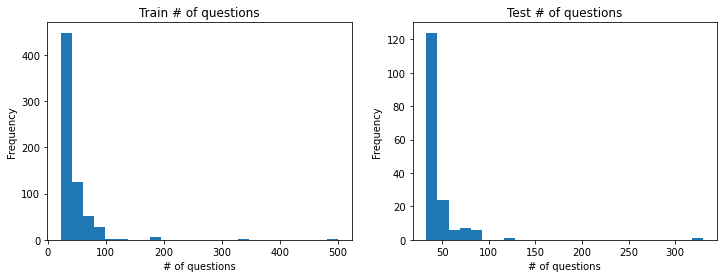

In [128]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))
df_tournaments_processed \
    .query(f"year == {TRAIN_YEAR}").cnt_questions \
    .plot(kind='hist', bins=25, ax=ax[0], title='Train # of questions')

df_tournaments_processed \
    .query(f"year == {TEST_YEAR}").cnt_questions \
    .plot(kind='hist', bins=25, ax=ax[1], title='Test # of questions')

for ax_i in ax:
    ax_i.set_xlabel("# of questions")

In [131]:
# we could drop tournaments with anomaly number of questions (< 100 would be OK):
df_tournaments_processed = df_tournaments_processed.loc[df_tournaments_processed.cnt_questions < 100, :]

In [135]:
print("Remaining number of tournaments after preprocessing:")
df_tournaments_processed.year.value_counts()

Remaining number of tournaments after preprocessing:


2019    652
2020    167
Name: year, dtype: int64

__Task #2__

Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:
- повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
- в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
- для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.


__Task #3__

Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:
- предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
- в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью,
1 усреднённые по тестовому множеству турниров .


__Task #4__

Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:
- предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
- разработайте EM-схему для обучения этой модели, реализуйте её в коде;
- обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.

__Task #5__

А что там с вопросами? Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)? Если будет интересно: постройте топ сложных и простых вопросов со ссылками на конкретные записи в базе вопросов ЧГК (это чисто техническое дело, тут никакого ML нету).